# Modeling



In [39]:
import os

import joblib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn import preprocessing
from sklearn import set_config
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier # <- boosting model
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder


from sklearn.pipeline import Pipeline


set_config(display='diagram')   

LABEL_COLUMN = "churned"

# Load Dataset

In [2]:
train = pd.read_csv('../data/users_train.csv')
test = pd.read_csv('../data/users_test.csv')

x_train, y_train = train.drop(columns=[LABEL_COLUMN]), train[LABEL_COLUMN]
x_test, y_test = test.drop(columns=[LABEL_COLUMN]), test[LABEL_COLUMN]

# Modelos boosting

## Solo variables numericas
### Tranformer

In [3]:
NUMERICAL_COLUMNS = [
    "cnt_user_engagement",
    "cnt_level_start_quickplay",
    "cnt_level_end_quickplay",
    "cnt_level_complete_quickplay",
    "cnt_level_reset_quickplay",
    "cnt_post_score",
    "cnt_spend_virtual_currency",
    "cnt_ad_reward",
    "cnt_challenge_a_friend",
    "cnt_completed_5_levels",
    "cnt_use_extra_steps",
]
IGNORE_COLUMNS = [
    "user_first_engagement",
    "user_pseudo_id",
    "is_enable",
    "bounced",
    "device_lang",
    "country_name",
    "device_os",
    "device_lang",
]

transformer_numeric = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("scaler", preprocessing.StandardScaler()),
    ]
)
transformer_pipeline = ColumnTransformer(
    transformers=[
        ("numeric_features", transformer_numeric, NUMERICAL_COLUMNS),
        ("ignore_features", "drop", IGNORE_COLUMNS),
    ]
)


### Gradient boosting model
En este caso en lugar de usar un modelo lineal puedes probar uno de boosting `GradientBoostingClassifier(random_state=42)`

In [4]:
gb_model = Pipeline(
    steps=[
        ('preprocessor', transformer_pipeline),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ]
)
gb_model.fit(x_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric_features', ...), ('ignore_features', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluation

              precision    recall  f1-score   support

           0       0.77      0.98      0.87       614
           1       0.42      0.04      0.08       185

    accuracy                           0.76       799
   macro avg       0.60      0.51      0.47       799
weighted avg       0.69      0.76      0.68       799



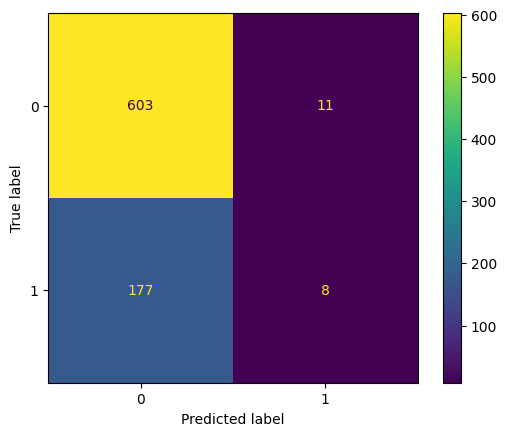

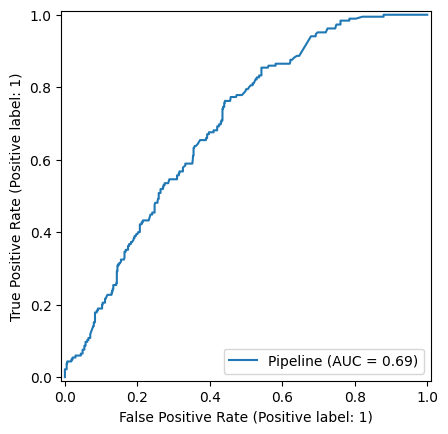

In [6]:
x = x_test
y = y_test
model = gb_model

y_pred = model.predict(x)
print(metrics.classification_report(y, y_pred))

metrics.ConfusionMatrixDisplay.from_estimator(model, x, y)

f, ax = plt.subplots()
metrics.RocCurveDisplay.from_estimator(model, x, y, ax=ax)

## Numerical and Categorical features

### Transformer
El poder construir pipeline nos permite fácilmente experimentar muy rápido el efecto de las features que usamos así como las transformaciones que realizamos sobre estas.

In [7]:
CATEGORICAL_COLUMNS = [
    "country_name",
    "device_os",
    "device_lang",
]
NUMERICAL_COLUMNS = [
    "cnt_user_engagement",
    "cnt_level_start_quickplay",
    "cnt_level_end_quickplay",
    "cnt_level_complete_quickplay",
    "cnt_level_reset_quickplay",
    "cnt_post_score",
    "cnt_spend_virtual_currency",
    "cnt_ad_reward",
    "cnt_challenge_a_friend",
    "cnt_completed_5_levels",
    "cnt_use_extra_steps",
]
IGNORE_COLUMNS = [
    "user_first_engagement",
    "user_pseudo_id",
    "is_enable",
    "bounced",
    "device_lang",
]

transformer_numeric = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("scaler", preprocessing.StandardScaler()),
    ]
)
transformer_categorical = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("one-hot", preprocessing.OneHotEncoder(handle_unknown="ignore")),
    ]
)
transformer_pipeline = ColumnTransformer(
    transformers=[
        ("numeric_features", transformer_numeric, NUMERICAL_COLUMNS),
        ("categorical_features", transformer_categorical, CATEGORICAL_COLUMNS),
        ("ignore_features", "drop", IGNORE_COLUMNS),
    ]
)

### Modeling

In [8]:
gb_model_full = Pipeline(
    steps=[
        ('preprocessor', transformer_pipeline),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ]
)
gb_model_full.fit(x_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric_features', ...), ('categorical_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluation

              precision    recall  f1-score   support

           0       0.78      0.99      0.87       614
           1       0.58      0.06      0.11       185

    accuracy                           0.77       799
   macro avg       0.68      0.52      0.49       799
weighted avg       0.73      0.77      0.69       799



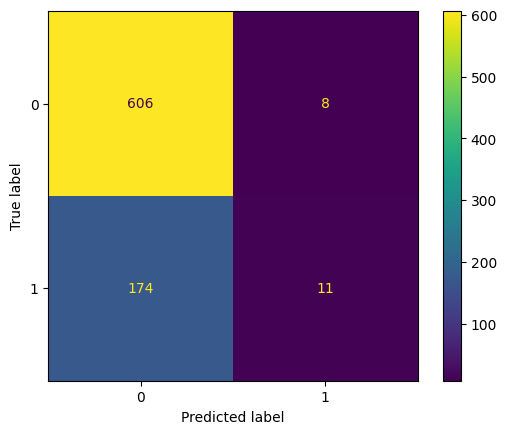

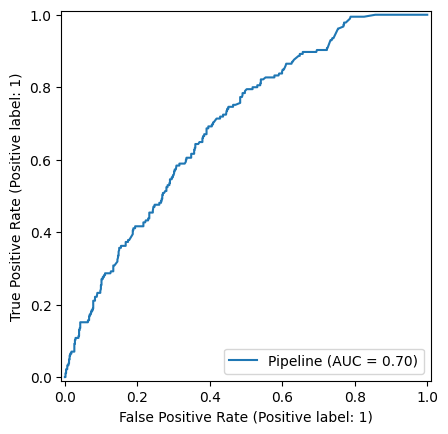

In [10]:
x = x_test
y = y_test
model = gb_model_full

y_pred = model.predict(x)
print(metrics.classification_report(y, y_pred))

metrics.ConfusionMatrixDisplay.from_estimator(model, x, y)

f, ax = plt.subplots()
metrics.RocCurveDisplay.from_estimator(model, x, y, ax=ax)

## Numerical and Categorical features with native categrical support

### Transformer
Esta vez en lugar de hacer one-hot encoding usaremos la capacidad nativa de boosting para manejar variables categóricas.

In [57]:
CATEGORICAL_COLUMNS = [
    "country_name",
    "device_os",
    "device_lang",
]
NUMERICAL_COLUMNS = [
    "cnt_user_engagement",
    "cnt_level_start_quickplay",
    "cnt_level_end_quickplay",
    "cnt_level_complete_quickplay",
    "cnt_level_reset_quickplay",
    "cnt_post_score",
    "cnt_spend_virtual_currency",
    "cnt_ad_reward",
    "cnt_challenge_a_friend",
    "cnt_completed_5_levels",
    "cnt_use_extra_steps",
]
IGNORE_COLUMNS = [
    "user_first_engagement",
    "user_pseudo_id",
    "is_enable",
    "bounced",
    "device_lang",
]

transformer_numeric = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("scaler", preprocessing.StandardScaler()),
    ]
)
transformer_categorical = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)),
    ]
)
transformer_pipeline = ColumnTransformer(
    transformers=[
        ("numeric_features", transformer_numeric, NUMERICAL_COLUMNS),
        ("categorical_features", transformer_categorical, CATEGORICAL_COLUMNS),
        ("ignore_features", "drop", IGNORE_COLUMNS),
    ]
)

### Modeling

In [54]:
gb_model_full = Pipeline(
    steps=[
        ('preprocessor', transformer_pipeline),
        ('classifier', 
         HistGradientBoostingClassifier(
            random_state=42, 
            categorical_features="from_dtype",
            class_weight="balanced"
            )
        )
    ]
)
gb_model_full.fit(x_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric_features', ...), ('categorical_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluation

In [55]:
model.named_steps['preprocessor'].get_feature_names_out()

array(['numeric_features__cnt_user_engagement',
       'numeric_features__cnt_level_start_quickplay',
       'numeric_features__cnt_level_end_quickplay',
       'numeric_features__cnt_level_complete_quickplay',
       'numeric_features__cnt_level_reset_quickplay',
       'numeric_features__cnt_post_score',
       'numeric_features__cnt_spend_virtual_currency',
       'numeric_features__cnt_ad_reward',
       'numeric_features__cnt_challenge_a_friend',
       'numeric_features__cnt_completed_5_levels',
       'numeric_features__cnt_use_extra_steps',
       'categorical_features__country_name',
       'categorical_features__device_os',
       'categorical_features__device_lang'], dtype=object)

              precision    recall  f1-score   support

           0       0.86      0.67      0.75       614
           1       0.37      0.64      0.47       185

    accuracy                           0.66       799
   macro avg       0.61      0.65      0.61       799
weighted avg       0.75      0.66      0.69       799



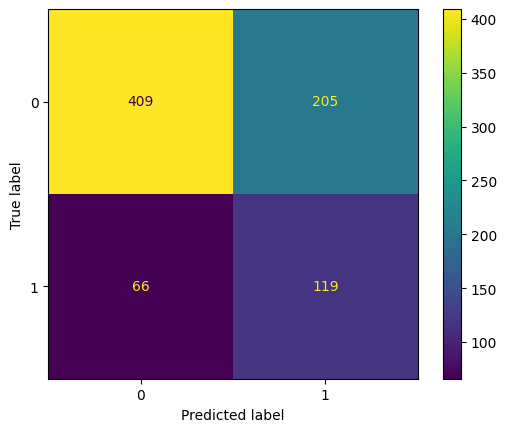

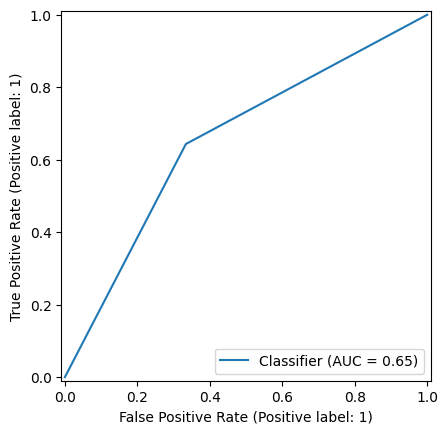

In [56]:
x = x_test
y = y_test
model = gb_model_full

y_pred = model.predict(x)
print(metrics.classification_report(y, y_pred))

metrics.ConfusionMatrixDisplay.from_predictions(y, y_pred)

f, ax = plt.subplots()
metrics.RocCurveDisplay.from_predictions(y, y_pred, ax=ax)

## Numerical and Categorical features

### Transformer
El poder construir pipeline nos permite fácilmente experimentar muy rápido el efecto de las features que usamos así como las transformaciones que realizamos sobre estas.

In [ ]:
CATEGORICAL_COLUMNS = [
    "country_name",
    "device_os",
    "device_lang",
]
NUMERICAL_COLUMNS = [
    "cnt_user_engagement",
    "cnt_level_start_quickplay",
    "cnt_level_end_quickplay",
    "cnt_level_complete_quickplay",
    "cnt_level_reset_quickplay",
    "cnt_post_score",
    "cnt_spend_virtual_currency",
    "cnt_ad_reward",
    "cnt_challenge_a_friend",
    "cnt_completed_5_levels",
    "cnt_use_extra_steps",
]
IGNORE_COLUMNS = [
    "user_first_engagement",
    "user_pseudo_id",
    "is_enable",
    "bounced",
    "device_lang",
]

transformer_numeric = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("scaler", preprocessing.StandardScaler()),
    ]
)
transformer_categorical = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("one-hot", preprocessing.OneHotEncoder(handle_unknown="ignore")),
    ]
)
transformer_pipeline = ColumnTransformer(
    transformers=[
        ("numeric_features", transformer_numeric, NUMERICAL_COLUMNS),
        ("categorical_features", transformer_categorical, CATEGORICAL_COLUMNS),
        ("ignore_features", "drop", IGNORE_COLUMNS),
    ]
)

### Modeling

In [ ]:
gb_model_full = Pipeline(
    steps=[
        ('preprocessor', transformer_pipeline),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ]
)
gb_model_full.fit(x_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric_features', ...), ('categorical_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluation

              precision    recall  f1-score   support

           0       0.78      0.99      0.87       614
           1       0.58      0.06      0.11       185

    accuracy                           0.77       799
   macro avg       0.68      0.52      0.49       799
weighted avg       0.73      0.77      0.69       799



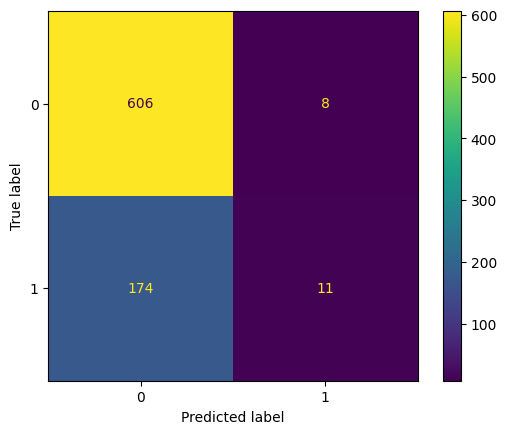

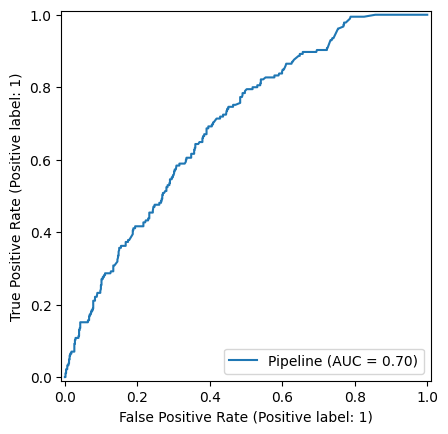

In [ ]:
x = x_test
y = y_test
model = gb_model_full

y_pred = model.predict(x)
print(metrics.classification_report(y, y_pred))

metrics.ConfusionMatrixDisplay.from_estimator(model, x, y)

f, ax = plt.subplots()
metrics.RocCurveDisplay.from_estimator(model, x, y, ax=ax)

In [24]:
y

0      1
1      0
2      0
3      1
4      0
      ..
794    0
795    0
796    0
797    0
798    0
Name: churned, Length: 799, dtype: int64

## Save model 

In [11]:
model_path = 'models'
if not os.path.exists(model_path):
    os.makedirs(model_path)

joblib.dump(gb_model_full, f'{model_path}/gb_model_full.joblib')

['models/gb_model_full.joblib']